In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
extract_to_path = '/kaggle/input/lfw-dataset'
os.makedirs(extract_to_path, exist_ok=True)
extracted_files = os.listdir(extract_to_path)
extracted_files

['mismatchpairsDevTrain.csv',
 'matchpairsDevTest.csv',
 'pairs.csv',
 'lfw_allnames.csv',
 'peopleDevTest.csv',
 'lfw-deepfunneled',
 'people.csv',
 'peopleDevTrain.csv',
 'mismatchpairsDevTest.csv',
 'lfw_readme.csv',
 'matchpairsDevTrain.csv']

In [3]:
import os
import pandas as pd
import shutil

# Define paths
base_dir = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/'
metadata_dir = '/kaggle/input/lfw-dataset'
output_dir = "/kaggle/working/"
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Ensure the output directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Load metadata for splits
train_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTrain.csv'))
test_metadata = pd.read_csv(os.path.join(metadata_dir, 'peopleDevTest.csv'))

# Function to normalize person names
def normalize_name(name):
    return '_'.join(name.replace('_', ' ').split()).strip()

# Function to copy images into training and testing folders
def prepare_dataset(df, img_folder, dest_folder):
    for index, row in df.iterrows():
        person_name = normalize_name(row['name'])
        images_count = int(row['images'])
        person_dir = os.path.join(dest_folder, person_name)  # Folder for the person
        os.makedirs(person_dir, exist_ok=True)

        # Format the image filename
        for i in range(1, images_count + 1):
            filename = f"{person_name}_{i:04d}.jpg"
            source_path = os.path.join(img_folder, person_name, filename)
            dest_path = os.path.join(person_dir, filename)

            # Check if the source file exists and copy
            if os.path.exists(source_path):
                shutil.copy(source_path, dest_path)
            else:
                print(f"Warning: File not found - {source_path}")

# Copy training images
prepare_dataset(train_metadata, base_dir, train_dir)

# Copy testing images
prepare_dataset(test_metadata, base_dir, test_dir)

# Function to count files in directories
def count_files(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

# Print counts to verify
print(f"Total training images: {count_files(train_dir)}")
print(f"Total testing images: {count_files(test_dir)}")

Total training images: 9525
Total testing images: 3708


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and path to directories
img_width, img_height = 224, 224  # Size required by VGG16 model
train_dir = '/kaggle/working/train/'
test_dir = '/kaggle/working/test/'

# Initialize VGG16 base model, pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the layers of the base model to prevent them from being updated during training
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout for regularization

# Assuming the number of classes is fetched from the directory structure
num_classes = len(os.listdir(train_dir))  # This should match the number of folders in train_dir

output_layer = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary to check the final model architecture
model.summary()


2024-05-04 19:25:32.751259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 19:25:32.751367: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 19:25:32.879858: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4038)           │     2,071,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,631,750 (113.04 MB)

 Trainable params: 14,917,062 (56.90 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [5]:
# Setup data generators with augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation data

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical'
)

Found 9525 images belonging to 4038 classes.
Found 3708 images belonging to 1711 classes.


In [6]:
import os

train_dir = '/kaggle/working/train/'
test_dir = '/kaggle/working/test/'

# List all classes from both directories
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

# Combine lists and remove duplicates
all_classes = sorted(set(train_classes + test_classes))

print(f"Total classes: {len(all_classes)}")

Total classes: 5749


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 224, 224  # Size required by VGG16 model

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Use the complete list of classes for both generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical',
    classes=all_classes  # specify all classes explicitly
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=20,
    class_mode='categorical',
    classes=all_classes  # specify all classes explicitly
)

Found 9525 images belonging to 5749 classes.
Found 3708 images belonging to 5749 classes.


In [8]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create new top layers
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(all_classes), activation='softmax')(x)  # Use the total number of unique classes

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary to confirm the setup
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5749)           │     2,949,237 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,509,493 (116.38 MB)

 Trainable params: 15,794,805 (60.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
# Set training parameters
epochs = 10
batch_size = 20
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# Start training the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps
)

# Save the trained model
model.save('/kaggle/working/vgg16_face_recognition_model.h5')

# Optionally, print the history of training
print(history.history)


Epoch 1/10


2024-05-04 19:25:53.241203: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-05-04 19:25:53.241254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-05-04 19:25:53.241263: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-05-04 19:25:53.241271: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-05-04 19:25:53.241279: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-05-04 19:25:53.241287: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-05-04 19:25:53.241294: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-05-04 19:25:53.241302: 

  2/476 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.0250 - loss: 54.4638      

I0000 00:00:1714850765.144302     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714850765.167455     100 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


399/476 ━━━━━━━━━━━━━━━━━━━━ 16s 210ms/step - accuracy: 0.0230 - loss: 21.6853

2024-05-04 19:27:29.838541: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.09291, expected 2.38321
2024-05-04 19:27:29.838607: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.88251, expected 5.1728
2024-05-04 19:27:29.838617: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.48389, expected 4.77418
2024-05-04 19:27:29.838625: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.23066, expected 4.52095
2024-05-04 19:27:29.838632: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.78972, expected 5.08001
2024-05-04 19:27:29.838640: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.97856, expected 4.26885
2024-05-04 19:27:29.838648: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.36704, expected 3.65734
2024-05-04 19:27:29.838655: 

476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.0257 - loss: 19.9373

W0000 00:00:1714850870.362704     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


476/476 ━━━━━━━━━━━━━━━━━━━━ 131s 241ms/step - accuracy: 0.0258 - loss: 19.9179 - val_accuracy: 0.0000e+00 - val_loss: 10.3260
Epoch 2/10
  1/476 ━━━━━━━━━━━━━━━━━━━━ 24s 51ms/step - accuracy: 0.0500 - loss: 8.9682

2024-05-04 19:27:59.837906: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 4.39009, expected 3.53025
2024-05-04 19:27:59.837965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.40727, expected 4.54742
2024-05-04 19:27:59.837980: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.56026, expected 4.70042
2024-05-04 19:27:59.837988: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.58812, expected 4.72827
2024-05-04 19:27:59.837996: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.9643, expected 4.10445
2024-05-04 19:27:59.838004: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 5.19898, expected 4.33914
2024-05-04 19:27:59.838012: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 5.47066, expected 4.61082
2024-05-04 19:27:59.838019: 

476/476 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.0500 - loss: 8.9682 - val_accuracy: 0.0000e+00 - val_loss: 10.3336
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 110s 227ms/step - accuracy: 0.0560 - loss: 7.6282 - val_accuracy: 0.0000e+00 - val_loss: 11.4551
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 81us/step - accuracy: 0.0000e+00 - loss: 7.5441 - val_accuracy: 0.0000e+00 - val_loss: 11.4786
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 110s 227ms/step - accuracy: 0.0569 - loss: 7.4594 - val_accuracy: 0.0000e+00 - val_loss: 12.1379
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 83us/step - accuracy: 0.0500 - loss: 7.7327 - val_accuracy: 0.0000e+00 - val_loss: 12.1206
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.0534 - loss: 7.4174 - val_accuracy: 0.0000e+00 - val_loss: 12.6411
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 0s 87us/step - accuracy: 0.0000e+00 - loss: 7.8557 - val_accuracy: 0.0000e+00 - val_loss: 12.6418
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 151s 247ms/step 

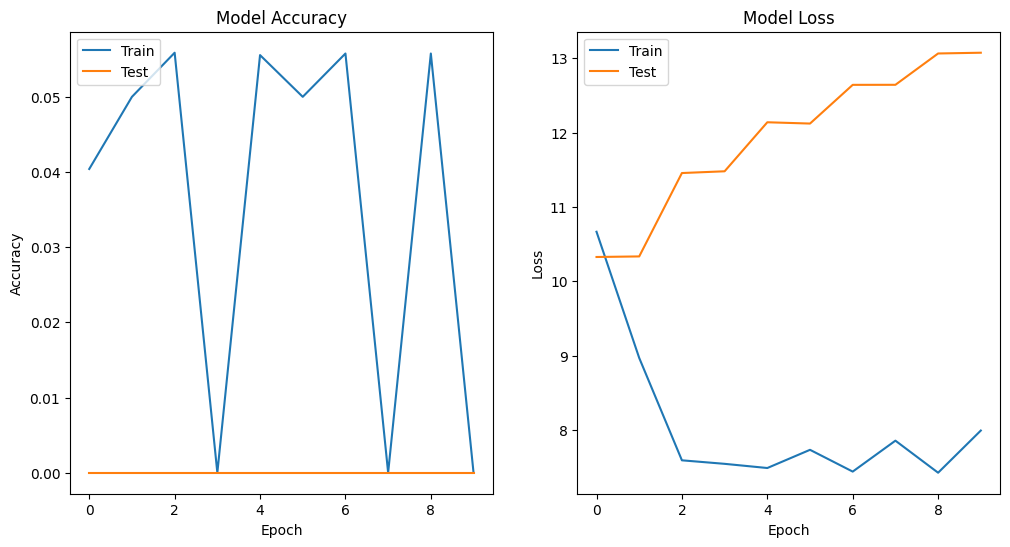

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

**Recognition**

In [11]:
import cv2
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity

In [12]:
# Load the face detection model
face_detector = cv2.dnn.readNetFromCaffe(
    '/kaggle/input/opencvfacerecognizer/opencv-face-recognizer/face_detection_model/deploy.prototxt', 
    '/kaggle/input/opencvfacerecognizer/opencv-face-recognizer/face_detection_model/res10_300x300_ssd_iter_140000.caffemodel')

# Load the model to extract face embeddings (here, using OpenFace as an example)
model_path = '/kaggle/input/opencvfacerecognizer/opencv-face-recognizer/openface_nn4.small2.v1.t7'
face_recognizer = cv2.dnn.readNetFromTorch(model_path)

In [13]:
def detect_faces(image, detector):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False)
    detector.setInput(blob)
    detections = detector.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Confidence threshold
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype(int)
            # Ensure the bounding box is fully within the image dimensions
            startX, startY, endX, endY = max(0, startX), max(0, startY), min(w-1, endX), min(h-1, endY)
            if endX > startX and endY > startY:  # Ensure the box is non-empty
                faces.append((startX, startY, endX, endY))
    return faces

def extract_features(face_image, recognizer):
    if face_image.size == 0:
        return None
    blob = cv2.dnn.blobFromImage(face_image, 1.0 / 255, (96, 96), (0, 0, 0), True, False)
    recognizer.setInput(blob)
    return recognizer.forward()


In [14]:
image_folder = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
embeddings = []
labels = []

for person_name in os.listdir(image_folder):
    person_folder = os.path.join(image_folder, person_name)
    for image_name in os.listdir(person_folder):
        image_path = os.path.join(person_folder, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            faces = detect_faces(image, face_detector)
            for face in faces:
                x, y, x2, y2 = face
                face_img = image[y:y2, x:x2]
                embedding = extract_features(face_img, face_recognizer)
                if embedding is not None:
                    embeddings.append(embedding)
                    labels.append(person_name)


In [15]:
def recognize_face(input_embedding, embeddings, labels, threshold=0.5):
    max_similarity = 0
    recognized_label = "Unknown"
    for i, existing_embedding in enumerate(embeddings):
        similarity = cosine_similarity(input_embedding.reshape(1, -1), existing_embedding.reshape(1, -1))
        if similarity > max_similarity:
            max_similarity = similarity
            if max_similarity > threshold:
                recognized_label = labels[i]
    return recognized_label

In [16]:
# Import necessary libraries
import cv2
import numpy as np

# Path to the image you want to test
test_image_path = '/kaggle/input/opencvfacerecognizer/opencv-face-recognizer/images/unknown2.jpg'

# Read the image
test_image = cv2.imread(test_image_path)
if test_image is None:
    print("Image not found or unable to read.")

# Perform face detection
faces = detect_faces(test_image, face_detector)
if not faces:
    print("No faces detected.")

# Loop through detected faces
for face in faces:
    x, y, x2, y2 = face
    # Extract the face region from the image
    face_img = test_image[y:y2, x:x2]

    # Ensure the face region is not empty
    if face_img.size != 0:
        # Extract features (embeddings) of the detected face
        input_embedding = extract_features(face_img, face_recognizer)
        
        if input_embedding is not None:
            # Recognize the face by comparing it against stored embeddings
            recognized_person = recognize_face(input_embedding, embeddings, labels)
            print(f"Recognized: {recognized_person}")
        else:
            print("Unable to extract features from the face.")
    else:
        print("Detected face region is invalid.")


Recognized: Rupert_Grint
Recognized: Oprah_Winfrey
Recognized: Colin_Powell
Recognized: Jennifer_Lopez


In [17]:
def recognize_face(input_embedding, embeddings, labels, threshold=0.5):
    max_similarity = 0
    recognized_label = "Unknown"
    for i, existing_embedding in enumerate(embeddings):
        # Assume embeddings are numpy arrays and calculate cosine similarity
        similarity = np.dot(input_embedding.flatten(), existing_embedding.flatten()) / (
            np.linalg.norm(input_embedding.flatten()) * np.linalg.norm(existing_embedding.flatten()))
        
        if similarity > max_similarity:
            max_similarity = similarity
            if max_similarity > threshold:
                recognized_label = labels[i]
    
    return recognized_label, max_similarity  # Ensure you return both values


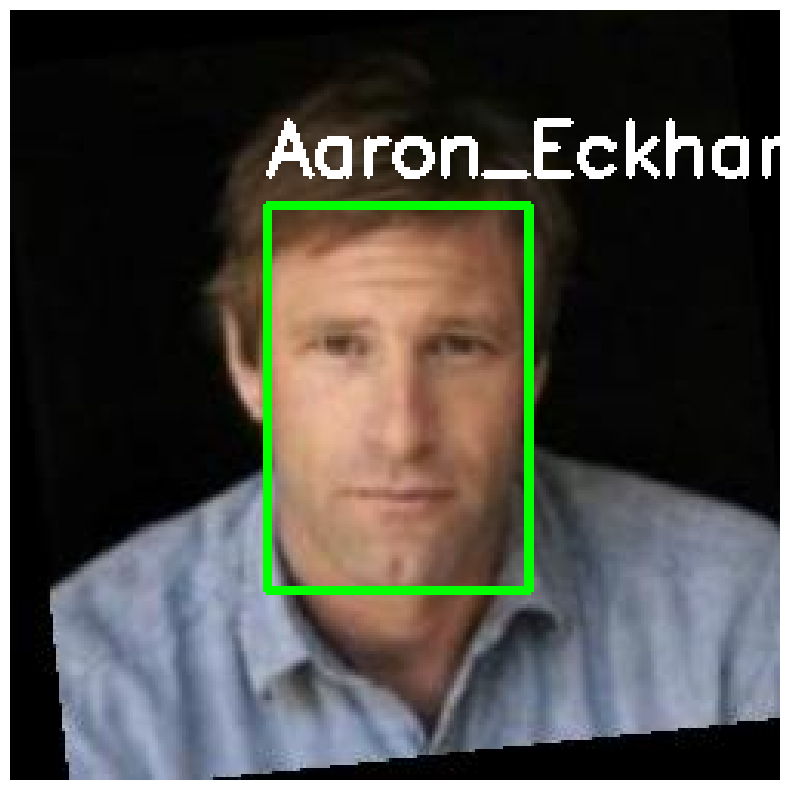

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
test_image_path = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
test_image = cv2.imread(test_image_path)

if test_image is None:
    print("Image not found or unable to read.")
else:
    # Perform face detection
    faces = detect_faces(test_image, face_detector)
    
    if not faces:
        print("No faces detected.")
    
    for face in faces:
        x, y, x2, y2 = face
        face_img = test_image[y:y2, x:x2]

        if face_img.size != 0:
            input_embedding = extract_features(face_img, face_recognizer)

            if input_embedding is not None:
                recognized_person, similarity = recognize_face(input_embedding, embeddings, labels)
                
                # Drawing the face bounding box
                cv2.rectangle(test_image, (x, y), (x2, y2), (0, 255, 0), 2)
                
                # Adding the recognition label and similarity score
                label = f"{recognized_person}, Sim: {similarity:.2f}"
                cv2.putText(test_image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                
            else:
                print("Unable to extract features from the face.")
        else:
            print("Detected face region is invalid.")

    # Convert from BGR to RGB for display
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))  # You can adjust the display size
    plt.imshow(test_image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()


In [19]:
def detect_faces(image, detector):
    h, w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0), False, False)
    detector.setInput(blob)
    detections = detector.forward()
    faces = []
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:  # Adjust this threshold as needed
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            startX, startY, endX, endY = box.astype(int)
            faces.append((startX, startY, endX, endY, confidence))
    return faces


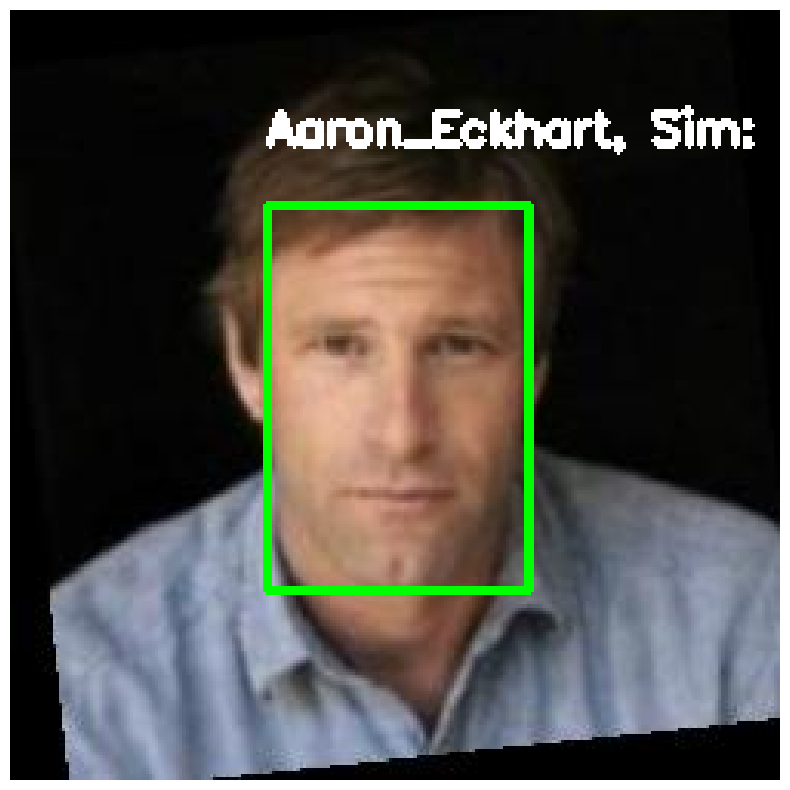

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
test_image_path = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
test_image = cv2.imread(test_image_path)

if test_image is None:
    print("Image not found or unable to read.")
else:
    # Perform face detection
    faces = detect_faces(test_image, face_detector)
    
    if not faces:
        print("No faces detected.")
    
    for (x, y, x2, y2, conf) in faces:
        face_img = test_image[y:y2, x:x2]

        if face_img.size != 0:
            input_embedding = extract_features(face_img, face_recognizer)

            if input_embedding is not None:
                recognized_person, similarity = recognize_face(input_embedding, embeddings, labels)
                
                # Drawing the face bounding box
                cv2.rectangle(test_image, (x, y), (x2, y2), (0, 255, 0), 2)
                
                # Adding the recognition label, similarity score, and detection confidence
                label = f"{recognized_person}, Sim: {similarity:.2f}, Conf: {conf:.2f}"
                cv2.putText(test_image, label, (x, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                
            else:
                print("Unable to extract features from the face.")
        else:
            print("Detected face region is invalid.")

    # Convert from BGR to RGB for display
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))  # You can adjust the display size
    plt.imshow(test_image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()


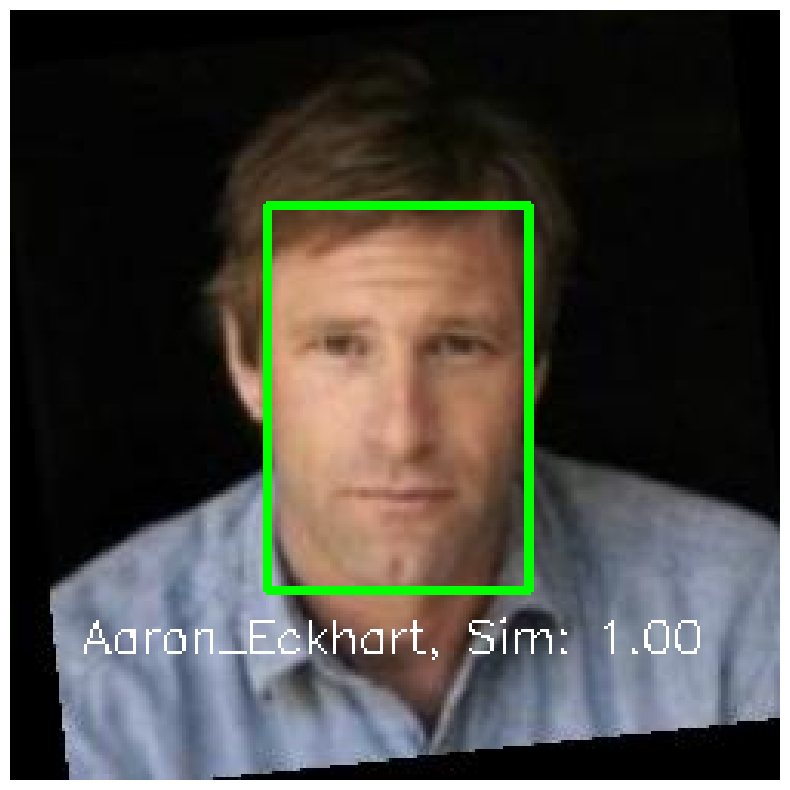

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load your image
test_image_path = '/kaggle/input/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg'
test_image = cv2.imread(test_image_path)

if test_image is None:
    print("Image not found or unable to read.")
else:
    # Perform face detection
    faces = detect_faces(test_image, face_detector)
    
    if not faces:
        print("No faces detected.")
    
    for (x, y, x2, y2, conf) in faces:
        face_img = test_image[y:y2, x:x2]

        if face_img.size != 0:
            input_embedding = extract_features(face_img, face_recognizer)

            if input_embedding is not None:
                recognized_person, similarity = recognize_face(input_embedding, embeddings, labels)
                
                # Drawing the face bounding box
                cv2.rectangle(test_image, (x, y), (x2, y2), (0, 255, 0), 2)
                
                # Prepare the text for display
                label = f"{recognized_person}, Sim: {similarity:.2f}"
                text_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                
                # Calculate text start position to be centered
                text_x = x + (x2 - x) // 2 - text_size[0] // 2
                text_y = y + y2 - y + 20  # Offset from the bottom of the bounding box

                # Adding the recognition label, similarity score, and detection confidence
                cv2.putText(test_image, label, (text_x, text_y), cv2.FONT_ITALIC, 0.5, (255, 255, 255), 1)
                
            else:
                print("Unable to extract features from the face.")
        else:
            print("Detected face region is invalid.")

    # Convert from BGR to RGB for display
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))  # You can adjust the display size
    plt.imshow(test_image_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()
